In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import math
import itertools
import re
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from src import analysis
from src import framework
from src import ab_tests
from src.framework import print_title

In [3]:
import importlib
importlib.reload(analysis)
importlib.reload(framework)
importlib.reload(ab_tests)

<module 'src.ab_tests' from '/Users/jobandtalent/Documents/GitHub/ab-test-framework/src/ab_tests.py'>

# EXPERIMENT RESULTS

## SOURCES INGESTION

### LOAD

In [4]:
# Load raw data
file_name = 'ab_test_example_1.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

,Unnamed: 0,u_id,platform,variant,duration,is_completed,event_at
0,0,0,apple,0,75.0,True,2023-10-18 19:00:52.284
1,1,1,apple,0,24.0,False,2024-02-09 02:28:41.894
2,2,2,apple,0,54.0,True,2024-02-10 02:55:37.475
3,3,3,apple,0,128.0,True,2024-02-10 02:46:21.855
4,4,4,apple,0,27.0,True,2023-09-01 23:51:13.967


-------------------- INITIAL DATA TYPES --------------------
Unnamed: 0        int64
u_id              int64
platform         object
variant           int64
duration        float64
is_completed       bool
event_at         object
dtype: object


### DTYPES

In [5]:
datetime_columns = ['event_at']
float64_columns = ['duration']
str_columns = ['variant', 'platform', 'u_id', 'is_completed']
int64_columns = ['']

# Basic data conversion
df = framework.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
Unnamed: 0               int64
u_id                    object
platform                object
variant                 object
duration               float64
is_completed            object
event_at        datetime64[ns]
dtype: object


,Unnamed: 0,u_id,platform,variant,duration,is_completed,event_at
0,0,0,apple,0,75.0,True,2023-10-18 19:00:52.284
1,1,1,apple,0,24.0,False,2024-02-09 02:28:41.894
2,2,2,apple,0,54.0,True,2024-02-10 02:55:37.475
3,3,3,apple,0,128.0,True,2024-02-10 02:46:21.855
4,4,4,apple,0,27.0,True,2023-09-01 23:51:13.967


## DATA CLEANING

### CHECKS

In [6]:
variant_column = 'variant'

In [7]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('VARIANT DISTRIBUTION')
display(df[variant_column].value_counts())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412912 entries, 0 to 1412911
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Unnamed: 0    1412912 non-null  int64         
 1   u_id          1412912 non-null  object        
 2   platform      1412912 non-null  object        
 3   variant       1412912 non-null  object        
 4   duration      1412912 non-null  float64       
 5   is_completed  1412912 non-null  object        
 6   event_at      1412912 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 75.5+ MB


None

----------------------- DF DESCRIBE -----------------------


,Unnamed: 0,duration,event_at
count,1.412912e+06,1.412912e+06,1412912
mean,7.064555e+05,7.858214e+01,2023-12-08 07:29:59.005399040
min,0.000000e+00,0.000000e+00,2023-05-01 00:00:18.230000
25%,3.532278e+05,1.100000e+01,2023-09-19 18:54:12.827249920
50%,7.064555e+05,4.700000e+01,2023-12-16 17:05:38.686500096
75%,1.059683e+06,1.050000e+02,2024-03-04 22:04:21.504750080
max,1.412911e+06,7.297100e+04,2024-05-27 23:59:57.466000
std,4.078727e+05,2.019494e+02,NaN


------------------- VARIANT DISTRIBUTION -------------------


variant
1    717257
0    695655
Name: count, dtype: int64

### DUPLICATES

In [8]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [9]:
primary_key_column = 'u_id'
timestamp_column = ''

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if timestamp_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(timestamp_column).drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on u_id column: 0


### NULLS

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
Unnamed: 0      0
u_id            0
platform        0
variant         0
duration        0
is_completed    0
event_at        0
dtype: int64


## METRICS DEFINITION

In [12]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_duration'] = df['duration']
df['metric_cvr_is_completed'] = df['is_completed'].apply(lambda x: 1 if x == 'True' else 0, 1)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_67149/3484529170.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['metric_cvr_is_completed'] = df['is_completed'].apply(lambda x: 1 if x == 'True' else 0, 1)


## SEGMENT ANALYSIS

### METRICS AND CONFIG SELECTION

In [13]:
# Select metrics and columns involved in the test
primary_key_column = 'u_id'
metric_column = 'metric_cvr_is_completed'
variant_column = 'variant'
segment_column = 'platform'

columns_selection_df = df[[primary_key_column, variant_column, segment_column, metric_column]]
metric_type = (
    'continuous' if metric_column.startswith('metric_cnt_') else
    'proportion' if metric_column.startswith('metric_cvr_') else
    None
)
outliers_filtered_df, is_strong_outlier_effect = analysis.remove_outliers(columns_selection_df, metric_column, 1)

# Filter outliers:
filter_outliers = False

if filter_outliers:
    selected_df = outliers_filtered_df.copy()
else:
    selected_df = columns_selection_df.copy()

display(selected_df.sample(5))

Low outlier limit: -1.0
Upper outlier limit: 2.0
Filtered 0 rows (0.00%) from 1412912 to 1412912
is_strong_outlier_effect: False


,u_id,variant,platform,metric_cvr_is_completed
161986,161986,0,apple,0
1031277,1031277,0,apple,1
418488,418488,1,google,0
1043485,1043485,0,apple,0
957103,957103,0,apple,0


### DATA ANALYSIS AND STATISTICAL TESTING BY SEGMENTS

======================================================================== SEGMENT: apple ========================================================================
::::::::::::::::::::::::::::::::::::::::::::::::::::::::: DATA ANALYSIS :::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Number of Variants: 2
Variants: ['0' '1']
Sample sizes per variant:
variant
1    636073
0    559811
Name: count, dtype: int64

Proportion per variant:
variant
1    0.531885
0    0.468115
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.14
------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -------------------------------


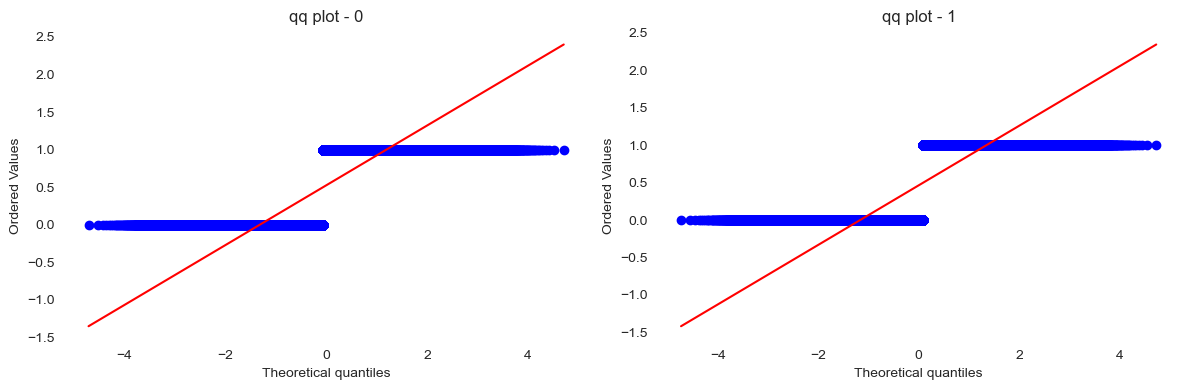

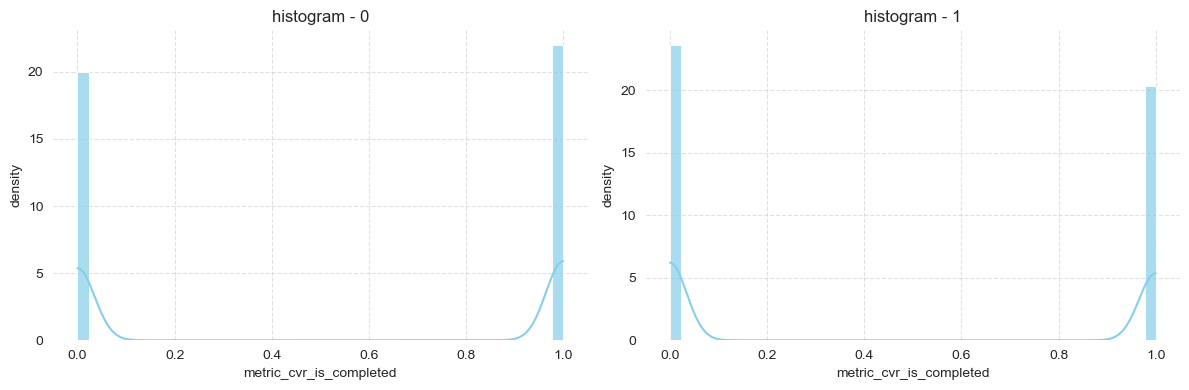

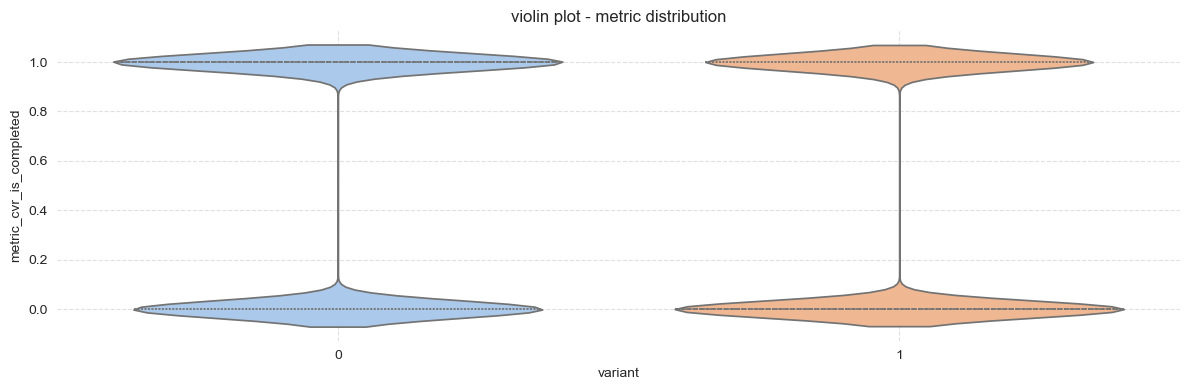

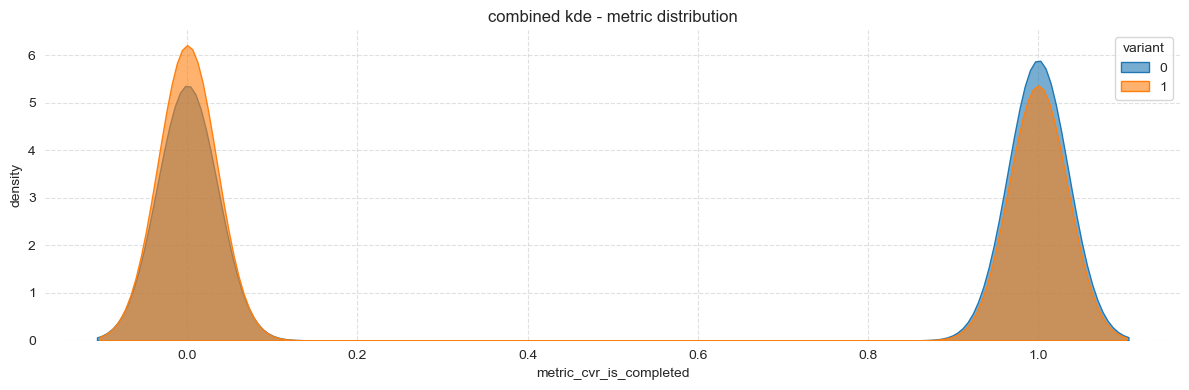

--------------------------------- NORMAL DISTRIBUTION TEST RESULTS ---------------------------------
variant 0: normaltest statistic = 1916799.7008, p-value = 0.0000
variant 1: normaltest statistic = 2195155.2756, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False
-------------------------------------- VARIANCE TEST RESULTS --------------------------------------
Levene test statistic = 205.9504, p_value = 0.0000
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False
::::::::::::::::::::::::::::::::::::::::::::::::::::::: STATISICAL TESTING :::::::::::::::::::::::::::::::::::::::::::::::::::::::
------------------------------------------ TEST VARIABLES ------------------------------------------
metric_type: proportion
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: variant
1    636073
0    559811
Name: count, dtype: int64
variant_ratio: 1.14
is_strong_outlier_effect: False


------------------------------------------ TEST SELECTION ---

,group1,group2,p_value,significant
0,"0 0 Name: group1, dtype: object","0 1 Name: group2, dtype: object","0 0.0 Name: p_value, dtype: float64","0 True Name: p_value, dtype: bool"


------------------------------------------ TEST SELECTION ------------------------------------------
{'use_two_proportion_z_test': True, 'use_bayesian_test': True}


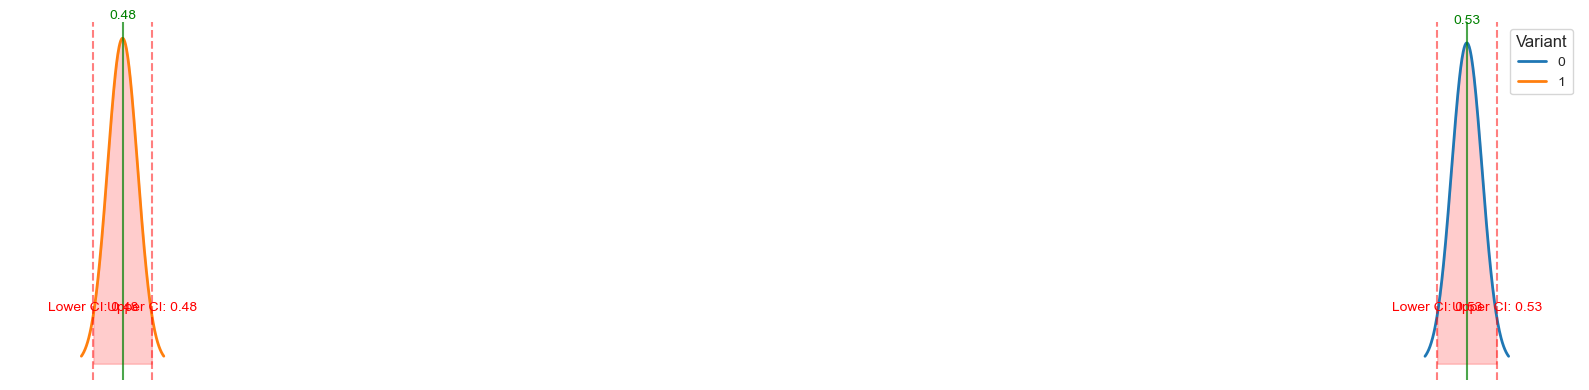

-------------------------------------- ADDITIONAL TECHNIQUES --------------------------------------


{'pairwise_tests': {'0 vs 1': {'bayesian_mean_difference': -0.052783801581857526,
   'bayesian_probability': 0.4777}}}

======================================================================= SEGMENT: google =======================================================================
::::::::::::::::::::::::::::::::::::::::::::::::::::::::: DATA ANALYSIS :::::::::::::::::::::::::::::::::::::::::::::::::::::::::
Number of Variants: 2
Variants: ['0' '1']
Sample sizes per variant:
variant
0    135844
1     81184
Name: count, dtype: int64

Proportion per variant:
variant
0    0.625928
1    0.374072
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.67
------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -------------------------------


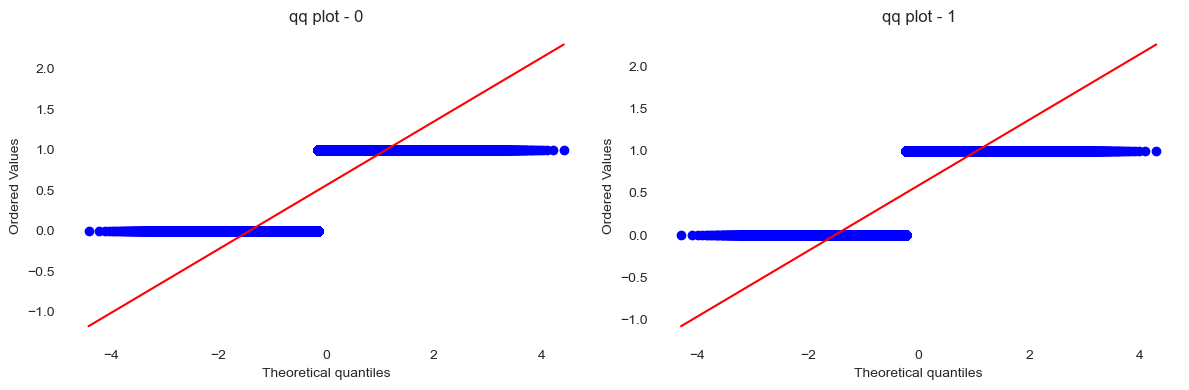

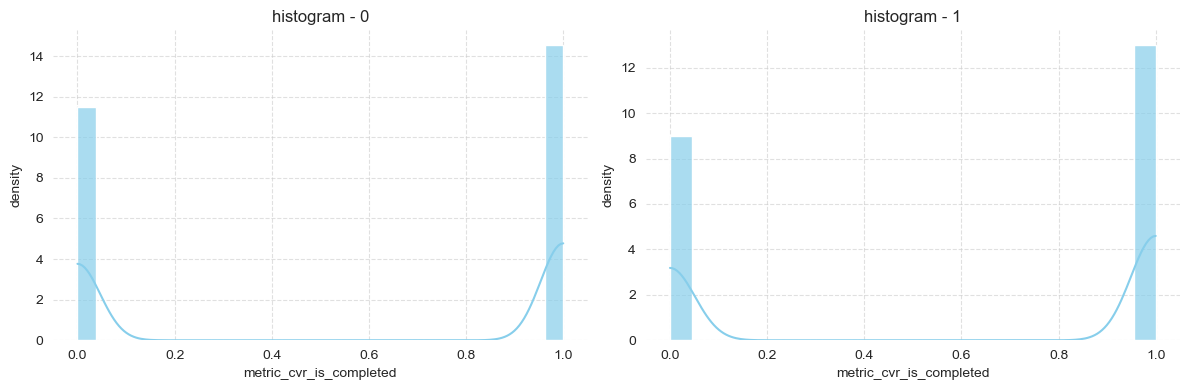

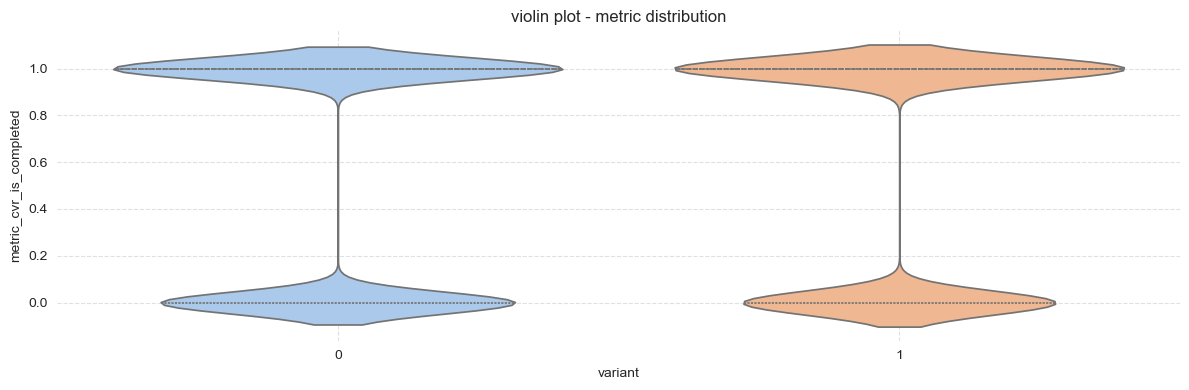

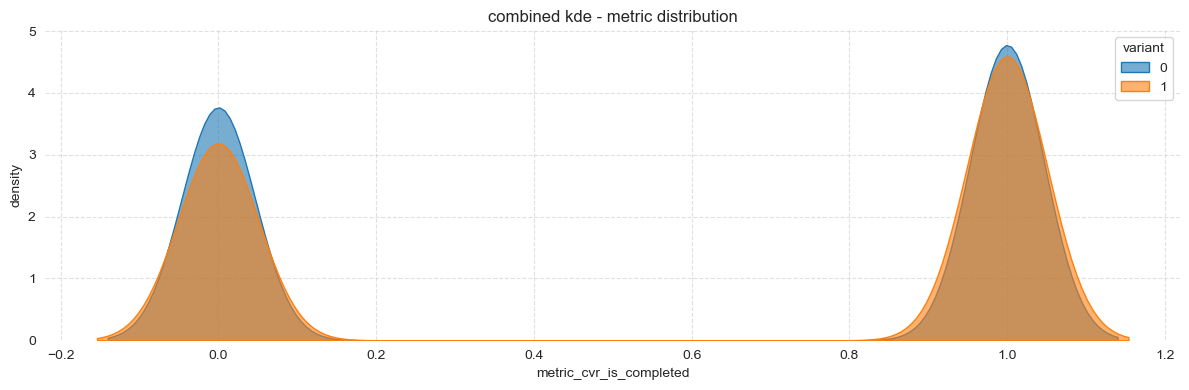

--------------------------------- NORMAL DISTRIBUTION TEST RESULTS ---------------------------------
variant 0: normaltest statistic = 479719.2094, p-value = 0.0000
variant 1: normaltest statistic = 303283.1784, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False
-------------------------------------- VARIANCE TEST RESULTS --------------------------------------
Levene test statistic = 205.2179, p_value = 0.0000
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False
::::::::::::::::::::::::::::::::::::::::::::::::::::::: STATISICAL TESTING :::::::::::::::::::::::::::::::::::::::::::::::::::::::
------------------------------------------ TEST VARIABLES ------------------------------------------
metric_type: proportion
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: variant
0    135844
1     81184
Name: count, dtype: int64
variant_ratio: 1.67
is_strong_outlier_effect: False


------------------------------------------ TEST SELECTION -----

,group1,group2,p_value,significant
0,"0 0 Name: group1, dtype: object","0 1 Name: group2, dtype: object","0 0.0 Name: p_value, dtype: float64","0 True Name: p_value, dtype: bool"


------------------------------------------ TEST SELECTION ------------------------------------------
{'use_two_proportion_z_test': True, 'use_bayesian_test': True}


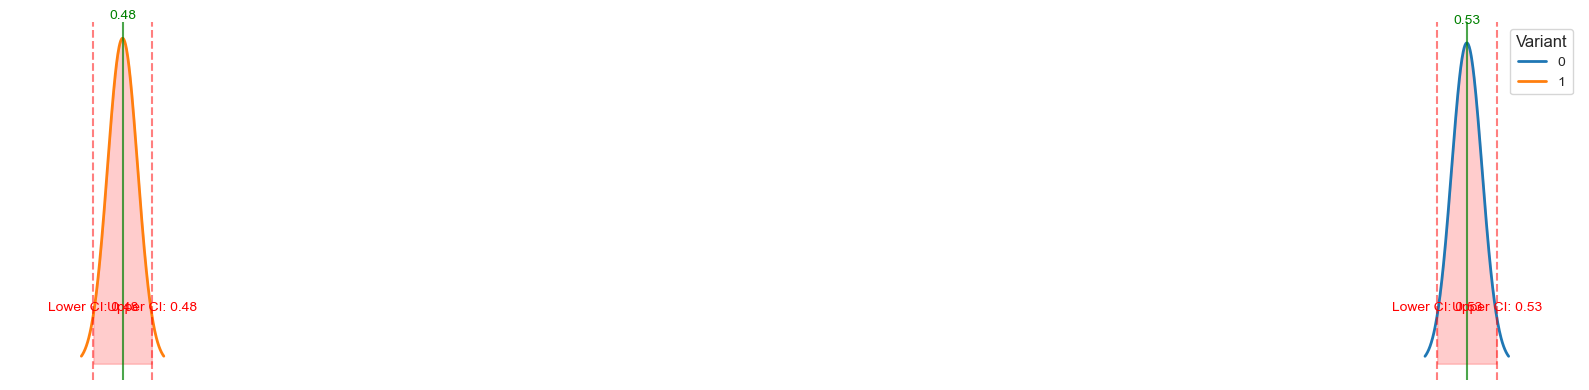

-------------------------------------- ADDITIONAL TECHNIQUES --------------------------------------


{'pairwise_tests': {'0 vs 1': {'bayesian_mean_difference': -0.052783801581857526,
   'bayesian_probability': 0.4721}}}

In [14]:
segments = selected_df[segment_column].unique()

for segment in segments:
    print_title('SEGMENT: ' + str(segment), 160, '=')
    print_title('DATA ANALYSIS', 130, ':')
    segment_df = selected_df[selected_df[segment_column] == segment]

    ### NUMBER OF VARIANTES
    num_variants = segment_df[variant_column].nunique()

    print(f"Number of Variants: {num_variants}")
    print(f"Variants: {segment_df[variant_column].unique()}")

    ### SAMPLE SIZES
    sample_sizes = segment_df[variant_column].value_counts()
    print("Sample sizes per variant:")
    print(sample_sizes)

    variant_proportion = sample_sizes / sample_sizes.sum()
    print("\nProportion per variant:")
    print(variant_proportion)

    variant_ratio = sample_sizes.max() / sample_sizes.min()
    print(f"\nVariant Ratio (N = max/min): {variant_ratio:.2f}")

    ### SAMPLE DISTRIBUTION
    sns.set_style("white")
    print_title('NORMAL DISTRIBUTION VISUAL ANALYSIS', 100)
    analysis.plot_qq(segment_df, variant_column, metric_column)
    analysis.plot_histogram_kde(segment_df, variant_column, metric_column)
    analysis.plot_violin(segment_df, variant_column, metric_column)
    analysis.plot_combined_kde(segment_df, variant_column, metric_column)

    print_title('NORMAL DISTRIBUTION TEST RESULTS', 100)
    distribution_results = analysis.calculate_distribution(segment_df, variant_column, metric_column)

    is_normal_distribution = analysis.set_normal_distribution_flag(distribution_results, alpha=0.05)
    print(f'\nUSE NORMAL DISTRIBUTION TESTS: {is_normal_distribution}')

    ### SAMPLE VARIANCES
    print_title('VARIANCE TEST RESULTS', 100)
    variance_results = analysis.calculate_variance_analysis(segment_df, variant_column, metric_column)

    is_equal_variance = analysis.set_equal_variance_flag(variance_results, alpha=0.05)
    print(f'\nUSE EQUAL VARIANCE TESTS: {is_equal_variance}')

    ## STATISICAL TESTING
    print_title('STATISICAL TESTING', 130, ':')
    ### TESTS AND TECHNIQUES SELECTION
    print_title('TEST VARIABLES', 100)
    ab_test_config = ab_tests.configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect)
    print('\n')
    print_title('TEST SELECTION', 100)
    print({key: value for key, value in ab_test_config.items() if value})

    ### UNBALANCE DATA
    segment_df = ab_tests.resample_data(segment_df, ab_test_config, variant_column)

    ### TESTS
    print_title('TEST RESULTS', 100)
    standardized_results = ab_tests.run_complete_ab_test(ab_test_config, selected_df, variant_column, metric_column, num_variants, alpha = 0.05)
    display(standardized_results)

    print_title('TEST SELECTION', 100)
    print({key: value for key, value in ab_test_config.items() if value})

    framework.plot_distributions(selected_df, variant_column, metric_column, 0.05)

    ### ADDITIONAL TECHNIQUES
    print_title('ADDITIONAL TECHNIQUES', 100)
    additional_tests_results = ab_tests.apply_additional_tests(ab_test_config, selected_df, variant_column, metric_column)
    display(additional_tests_results)

### INTERACTIONS TESTS

In [15]:
## Interaction Tests, if discrepancies between segments
use_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal
use_welch_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal, can unbalanced
use_kruskal_wallis_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, not normal
use_logistic_regression_interaction_test_segmentation = False # to test interaction effect for proportions, equivalent to ANOVA for categorical data
# if true, post hoc with tukey, games howell or dunn

In [16]:
interaction_tests = ab_tests.select_interaction_test(selected_df, variant_column, metric_column, segment_column, metric_type)

print(interaction_tests)

{'use_anova_interaction_test_segmentation': False, 'use_welch_anova_interaction_test_segmentation': False, 'use_kruskal_wallis_interaction_test_segmentation': False, 'use_two_way_anova_interaction_test_segmentation': False, 'use_logistic_regression_interaction_test_segmentation': True}


In [17]:
interaction_results = ab_tests.run_interaction_tests( selected_df, variant_column, metric_column, segment_column, interaction_tests)

for test, result in interaction_results.items():
    print(f"\n{test}:\n", result)

Optimization terminated successfully.
         Current function value: 0.689878
         Iterations 4

logistic_regression_interaction:
                            Logit Regression Results                           
Dep. Variable:          binary_metric   No. Observations:              1412912
Model:                          Logit   Df Residuals:                  1412908
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Feb 2025   Pseudo R-squ.:                0.004678
Time:                        18:43:49   Log-Likelihood:            -9.7474e+05
converged:                       True   LL-Null:                   -9.7932e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept          